Using Word2Vec to calculate the similarity between over 200 words across 19 cities. Variants of the same word within the same region are not considered in this analysis. For multiple variants, only first variant is selected for comparison with other regions. The primary focus of this study is to examine whether the similarity is higher within the same dialect, as well as to explore interesting linguistic phenomena.

In [1]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from collections import Counter
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import random
import plotly.graph_objects as go

Step 1. Data Cleanup  

Check the data and find out outliers.  
Prepare Data for the next analysis step.

In [2]:
# read the dataframe
data_df = pd.read_csv('forms.csv')
data_df

,ID,Local_ID,Language_ID,Parameter_ID,Value,Form,Segments,Comment,Source,Cognacy,Loan,Graphemes,Profile,Prosody,Morpheme_Glosses,Partial_Cognacy,Chinese_Characters
0,Beijing-91_vomit-1,NaN,Beijing,91_vomit,tʰu⁵¹,tʰu⁵¹,tʰ u ⁵¹,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t,spit/吐,1,吐
1,Haerbin-91_vomit-1,NaN,Haerbin,91_vomit,tʰu⁵³,tʰu⁵³,tʰ u ⁵³,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t,spit/吐,1,吐
2,Jinan-91_vomit-1,NaN,Jinan,91_vomit,tʰu³¹,tʰu³¹,tʰ u ³¹,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t,spit/吐,1,吐
3,Rongcheng-91_vomit-1,NaN,Rongcheng,91_vomit,ou²¹³⁻³⁵ tʰu²¹⁴,ou²¹³⁻³⁵ tʰu²¹⁴,ou ²¹³ + tʰ u ²¹⁴,copulative synonyme,Liu2007,NaN,NaN,NaN,NaN,n t + i n t,nausea/嘔 spit/吐,2 1,嘔 吐
4,Taiyuan-91_vomit-1,NaN,Taiyuan,91_vomit,tʰu⁵³ lə⁰,tʰu⁵³ lə⁰,tʰ u ⁵³ + l ə ⁰,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n t,nausea/嘔 _:PERFECTIVE/了,2 5,嘔 嘞
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4297,Guangzhou-90_woman-1,NaN,Guangzhou,90_woman,nøy²³ iɐn²¹⁻²³,nøy²³ iɐn²¹⁻²³,n øy ²³ + j ɐ n ²¹,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n c t,female/女 _person/人,39 38,女 人
4298,Fuzhou-90_woman-1,NaN,Fuzhou,90_woman,i⁵⁵⁻⁵³ tsia³²,i⁵⁵⁻⁵³ tsia³²,i ⁵⁵ + ts j a ³²,NaN,Liu2007,NaN,NaN,NaN,NaN,n t + i m n t,woman/伊 sister/姐,824 715,伊 姐
4299,Fuzhou-90_woman-2,NaN,Fuzhou,90_woman,ny³²⁻⁵⁵ ɛ²¹²,ny³²⁻⁵⁵ ɛ²¹²,n y ³² + ɛ ²¹²,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + n t,female/女 _world/界,39 825,女 界
4300,Fuzhou-90_woman-3,NaN,Fuzhou,90_woman,tsy⁵⁵ nøyŋ⁵³⁻⁵⁵ nøyŋ⁵³,tsy⁵⁵ nøyŋ⁵³⁻⁵⁵ nøyŋ⁵³,ts y ⁵⁵ + n øy ŋ ⁵³ + n øy ŋ ⁵³,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n c t + i n c t,woman/諸 female/娘 _person/人,749 31 38,諸 娘 儂


In [3]:
# get the info of the dataFrame columns
data_df.columns

Index(['ID', 'Local_ID', 'Language_ID', 'Parameter_ID', 'Value', 'Form',
       'Segments', 'Comment', 'Source', 'Cognacy', 'Loan', 'Graphemes',
       'Profile', 'Prosody', 'Morpheme_Glosses', 'Partial_Cognacy',
       'Chinese_Characters'],
      dtype='object')

In [4]:
# 19 cities  but there is variety among the same city 
cities = data_df['Language_ID'].unique()
cities

array(['Beijing', 'Haerbin', 'Jinan', 'Rongcheng', 'Taiyuan', 'XiAn',
       'Chengdu', 'Nanjing', 'Jixi', 'Suzhou', 'Wenzhou', 'Changsha',
       'Loudi', 'Nanchang', 'Meixian', 'Guilin', 'Guangzhou', 'Fuzhou',
       'Xiamen'], dtype=object)

In [5]:
# 203 words 
words = data_df['Parameter_ID'].unique()
words

array(['91_vomit', '92_fear', '93_skin', '94_float', '95_smooth',
       '96_wife', '97_all', '98_hot', '99_person', '100_throw', '1_white',
       '2_back', '3_nose', '4_ice', '5_neck', '6_thin', '7_not', '8_rub',
       '9_grass', '10_long', '101_flesh', '102_if', '103_breasts',
       '104_three', '105_woods', '106_kill', '107_sand', '108_mountain',
       '109_burn', '110_few', '111_tongue', '112_snake', '113_rope',
       '114_louse', '115_wet', '116_what', '117_stone', '118_hand',
       '119_tree', '120_bark', '121a_countnoun', '121b_countverb',
       '122_who', '123_water', '124_fruit', '125_sleep', '126_suck',
       '127_say', '128_split', '129_die', '130_four', '131_he',
       '132_they', '133_sun', '134_lie', '135_day', '136_sky', '137_hear',
       '138_head', '139_hair', '140_earth', '141_spit', '142_push',
       '143_leg', '144_dig', '145_play', '146_night', '147_tail',
       '148_smell', '149_i', '150_we', '151_five', '152_fog', '153_knee',
       '154_wash', '155_t

In [6]:
len(words)

203

In [8]:
# check which words have more than one variety in one area
multis = []
ones = []
for s in data_df['ID']:
    # ID format: city-para-index
    if int(s.split('-')[2]) != 1:
        multis.append(s)
    else:
        ones.append(s)
multis
# the later similarity comparison of different areas 
# first is the similarity of different areas
# second is the similarity of same parameter in same area : whether it is cluster ?

['Chengdu-91_vomit-2',
 'Chengdu-91_vomit-3',
 'Nanjing-91_vomit-2',
 'Loudi-91_vomit-2',
 'Nanchang-91_vomit-2',
 'Chengdu-92_fear-2',
 'Meixian-92_fear-2',
 'Meixian-92_fear-3',
 'Chengdu-93_skin-2',
 'Fuzhou-93_skin-2',
 'XiAn-94_float-2',
 'Nanjing-94_float-2',
 'Nanjing-94_float-3',
 'Jixi-94_float-2',
 'Wenzhou-94_float-2',
 'Nanchang-94_float-2',
 'Nanchang-94_float-3',
 'Fuzhou-94_float-2',
 'Haerbin-96_wife-2',
 'Haerbin-96_wife-3',
 'XiAn-96_wife-2',
 'XiAn-96_wife-3',
 'XiAn-96_wife-4',
 'Chengdu-96_wife-2',
 'Chengdu-96_wife-3',
 'Jixi-96_wife-2',
 'Changsha-96_wife-2',
 'Changsha-96_wife-3',
 'Changsha-96_wife-4',
 'Nanchang-96_wife-2',
 'Fuzhou-96_wife-2',
 'Fuzhou-96_wife-3',
 'Fuzhou-96_wife-4',
 'Chengdu-100_throw-2',
 'Changsha-100_throw-2',
 'Loudi-100_throw-2',
 'Nanchang-100_throw-2',
 'Fuzhou-100_throw-2',
 'Fuzhou-100_throw-3',
 'Taiyuan-1_white-2',
 'XiAn-2_back-2',
 'Taiyuan-3_nose-2',
 'Changsha-3_nose-2',
 'Xiamen-3_nose-2',
 'Changsha-4_ice-2',
 'Xiamen-4_ic

In [21]:
# total 4302
len(multis)

446

In [9]:
multis_df = data_df[data_df['ID'].isin(multis)]
multis_df

,ID,Local_ID,Language_ID,Parameter_ID,Value,Form,Segments,Comment,Source,Cognacy,Loan,Graphemes,Profile,Prosody,Morpheme_Glosses,Partial_Cognacy,Chinese_Characters
7,Chengdu-91_vomit-2,NaN,Chengdu,91_vomit,tʰu⁵³⁻⁵⁵ lo²¹,tʰu⁵³⁻⁵⁵ lo²¹,tʰ u ⁵³ + l o ²¹,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n t,spit/吐 _:PERFECTIVE/了,1 5,吐 了
8,Chengdu-91_vomit-3,NaN,Chengdu,91_vomit,ŋəu⁵³⁻⁴⁵ lo²¹,ŋəu⁵³⁻⁴⁵ lo²¹,ŋ əu ⁵³ + l o ²¹,!i,Liu2007,NaN,NaN,NaN,NaN,i n t + i n t,nausea/嘔 _:PERFECTIVE/了,2 5,嘔 了
10,Nanjing-91_vomit-2,NaN,Nanjing,91_vomit,əɯ¹¹⁻²² tʰu⁴⁴⁻²²,əɯ¹¹⁻²² tʰu⁴⁴⁻²²,əɯ ¹¹ + tʰ u ⁴⁴,copulative synonyme,Liu2007,NaN,NaN,NaN,NaN,n t + i n t,nausea/嘔 spit/吐,2 1,嘔 吐
16,Loudi-91_vomit-2,NaN,Loudi,91_vomit,ta³⁵⁻⁵ xue⁴²,ta³⁵⁻⁵ xue⁴²,t a ³⁵ + x w e ⁴²,!i,Liu2007,NaN,NaN,NaN,NaN,i n t + i m n t,_bear.carry/帶 vomit/?,9 768,帶 囗
18,Nanchang-91_vomit-2,NaN,Nanchang,91_vomit,tʰu²¹³,tʰu²¹³,tʰ u ²¹³,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t,spit/吐,1,吐
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,Nanjing-89_bird-2,NaN,Nanjing,89_bird,tɕʰioʔ⁵ tsɿ⁰,tɕʰioʔ⁵ tsɿ⁰,tɕʰ j o ʔ ⁵ + ts ɿ ⁰,NaN,Liu2007,NaN,NaN,NaN,NaN,i m n c t + i n t,bird/雀 _-child:SUF/子,746 19,雀 子
4286,Chengdu-90_woman-2,NaN,Chengdu,90_woman,ȵy⁵³⁻⁴⁵ li⁵⁵,ȵy⁵³⁻⁴⁵ li⁵⁵,ɲ y ⁵³ + l i ⁵⁵,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n t,female/女 _:GEN/的,39 40,女 的
4292,Changsha-90_woman-2,NaN,Changsha,90_woman,ȵy⁴¹ ti⁰,ȵy⁴¹ ti⁰,ɲ y ⁴¹ + t i ⁰,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n t,female/女 _:GEN/的,39 40,女 的
4299,Fuzhou-90_woman-2,NaN,Fuzhou,90_woman,ny³²⁻⁵⁵ ɛ²¹²,ny³²⁻⁵⁵ ɛ²¹²,n y ³² + ɛ ²¹²,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + n t,female/女 _world/界,39 825,女 界


In [10]:
multis_df.to_csv('multis.csv', columns=['ID', 'Language_ID', 'Parameter_ID','Chinese_Characters'],index=False, encoding='utf-8')

In [11]:
len(ones)

3856

length of ones should be 3857 (203 words * 19 cities), apparently there is a missing data, so next step is to find it out and does not count it in the similarity counting.


In [12]:
# find out the outlier
id_format_issues = [s for s in ones if len(s.split('-')) != 3]
# check id_format
if id_format_issues:
    print(f"Not well-formed ID: {id_format_issues}")

# count cities 
cities_in_ones = [s.split('-')[0] for s in ones]

city_counts = Counter(cities_in_ones)

print("Count of each city:")
for city in cities:
    print(f"{city}: {city_counts.get(city, 0)}")
# xiamen is not 203 times 

Count of each city:
Beijing: 203
Haerbin: 203
Jinan: 203
Rongcheng: 203
Taiyuan: 203
XiAn: 203
Chengdu: 203
Nanjing: 203
Jixi: 203
Suzhou: 203
Wenzhou: 203
Changsha: 203
Loudi: 203
Nanchang: 203
Meixian: 203
Guilin: 203
Guangzhou: 203
Fuzhou: 203
Xiamen: 202


In [13]:
# Xiamen is the city with 202 words and it is better to drop the word not the city data

# extract xiamen words list 
xiamen_ids = [s for s in ones if s.split('-')[0] == 'Xiamen']
xiamen_words_list = [s.split('-')[1] for s in xiamen_ids]


# find missing word 
missing_word = [word for word in words if word not in xiamen_words_list]
print(missing_word)

['190_grease']


In [14]:
# method to get infos of the same parameter_ID
def get_characters(para,info1,info2):
    return (data_df[data_df['Parameter_ID']== para][info1],data_df[data_df['Parameter_ID']== para][info2])


In [26]:
# check again, for 190_grease,  Xiamen data missing
get_characters('190_grease','ID','Chinese_Characters')


(2336      Beijing-190_grease-1
 2337      Haerbin-190_grease-1
 2338        Jinan-190_grease-1
 2339    Rongcheng-190_grease-1
 2340      Taiyuan-190_grease-1
 2341      Taiyuan-190_grease-2
 2342         XiAn-190_grease-1
 2343         XiAn-190_grease-2
 2344      Chengdu-190_grease-1
 2345      Nanjing-190_grease-1
 2346      Nanjing-190_grease-2
 2347         Jixi-190_grease-1
 2348         Jixi-190_grease-2
 2349       Suzhou-190_grease-1
 2350      Wenzhou-190_grease-1
 2351     Changsha-190_grease-1
 2352        Loudi-190_grease-1
 2353     Nanchang-190_grease-1
 2354     Nanchang-190_grease-2
 2355      Meixian-190_grease-1
 2356       Guilin-190_grease-1
 2357    Guangzhou-190_grease-1
 2358       Fuzhou-190_grease-1
 Name: ID, dtype: object,
 2336      脂 肪
 2337      脂 肪
 2338      脂 肪
 2339      脂 肪
 2340      脂 肪
 2341        油
 2342      脂 肪
 2343        油
 2344        油
 2345        油
 2346      脂 肪
 2347        油
 2348      脂 肪
 2349      壯 肉
 2350      脂 肪
 2351      脂 

Since 190_grease is not helpful with comparing the similarity among different areas, we remove this outlier, but it can be also used in the same area different varieties similarities comparison.


In [15]:
# compare the word 
word_items =[]
for i in ones:
    if i.split('-')[1] != '190_grease':
        chars = data_df[data_df['ID']==i]['Chinese_Characters']
        if not chars.empty:  # not put series type in a list
            word_items.append(chars.iloc[0])

In [20]:
# 202 words except 190_grease
len(word_items)

3838

In [23]:
# still save this for future use 
ones_df = data_df[data_df['ID'].isin(ones)]
ones_df.to_csv('ones.csv', columns=['ID', 'Language_ID', 'Parameter_ID','Chinese_Characters'],index=False, encoding='utf-8')

Step 2. Data analysis: calculate the similarity between words 

In [17]:
pwd()


'/Users/weiting/Desktop/2024summer semester/data linguistics'

In [20]:
cd tencent-ailab-embedding-zh-d100-v0.2.0


/Users/weiting/Desktop/2024summer semester/data linguistics/tencent-ailab-embedding-zh-d100-v0.2.0


In [21]:
# import word2vec Model
wv_from_text = KeyedVectors.load_word2vec_format('tencent-ailab-embedding-zh-d100-v0.2.0.txt', binary=False)
    

In [37]:
# define a funtion to do the similarities 
def get_similarity(word1, word2, model):
    word1 = word1.replace(' ', '')
    word2 = word2.replace(' ', '')
    if word1 == word2:
        return 1.0
    elif word1 in model.key_to_index and word2 in model.key_to_index:
        return round(model.similarity(word1, word2), 3)
    else:
        return 0.0


In [26]:
word_groups = [word_items[i:i + 19] for i in range(0, len(word_items), 19)]
word_groups[0]


['吐',
 '吐',
 '吐',
 '嘔 吐',
 '嘔 嘞',
 '嘔 吐',
 '發 吐 了',
 '吐',
 '㽹 惡',
 '嘔',
 '吐',
 '吐',
 '囗',
 '嘔',
 '翻',
 '吐',
 '嘔 吐',
 '吐',
 '吐']

In [46]:
# define the row labels for the dataframe
row_labels = [ f"{cities[ i %19]}_{variant}"for word_l in word_groups for i, variant in enumerate (word_l) ]
# define a method to create dataframe to show similarities 
area_similarity = pd.DataFrame(index=row_labels, columns=cities)
# turn the np array to list 
cities_list = cities.tolist()
# fill in the dataframe 
for word_list in word_groups:
    for i, c in enumerate(cities):
        row_label =  f"{cities[i % 19]}_{word_list[i]}"
        for city in cities:
            word_index = cities_list.index(city) % len(word_list)
            similar_word = word_list[word_index]
            area_similarity .at[row_label, city] = get_similarity(word_list[i], similar_word, wv_from_text)
area_similarity
# some none values due to the unrecognised words 

,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,Jixi,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
Beijing_吐,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.462,0.462
Haerbin_吐,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.462,0.462
Jinan_吐,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.462,0.462
Rongcheng_嘔 吐,0.581,0.581,0.581,1.0,0.0,1.0,0.0,0.581,0.0,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.0,0.581,0.581
Taiyuan_嘔 嘞,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meixian_妹 ? 人,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Guilin_女 人,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.586,1.0,0.772,0.565,0.0,1.0,1.0,0.232,0.453
Guangzhou_女 人,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.586,1.0,0.772,0.565,0.0,1.0,1.0,0.232,0.453
Fuzhou_伊 姐,0.232,0.0,0.232,0.232,0.232,0.232,0.232,0.232,0.0,0.232,0.247,0.232,0.278,0.32,0.0,0.232,0.232,1.0,0.228


In [47]:
# turn 0 to NaN value
area_similarity = area_similarity.astype(float)
area_similarity.replace(0,np.nan, inplace=True)
area_similarity


,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,Jixi,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
Beijing_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
Haerbin_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
Jinan_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
Rongcheng_嘔 吐,0.581,0.581,0.581,1.000,NaN,1.000,NaN,0.581,NaN,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.000,0.581,0.581
Taiyuan_嘔 嘞,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meixian_妹 ? 人,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN
Guilin_女 人,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.586,1.000,0.772,0.565,NaN,1.000,1.000,0.232,0.453
Guangzhou_女 人,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.586,1.000,0.772,0.565,NaN,1.000,1.000,0.232,0.453
Fuzhou_伊 姐,0.232,NaN,0.232,0.232,0.232,0.232,0.232,0.232,NaN,0.232,0.247,0.232,0.278,0.320,NaN,0.232,0.232,1.000,0.228


In [53]:
# store the area_similarity dataframe as a csv file 
# for further visualization 
area_similarity.to_csv('area_similarity.csv',float_format='%.3f', na_rep='NaN', index=True)

In [ ]:
# use Geospatial to show the similarity 
# https://piktochart.com/blog/big-data-visualization/

Step 3. Use area-similarity file, handling the Missing data

In [5]:
simi_df = pd.read_csv("area_similarity.csv")
simi_df

,Unnamed: 0,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,Jixi,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
0,Beijing_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
1,Haerbin_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
2,Jinan_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
3,Rongcheng_嘔 吐,0.581,0.581,0.581,1.000,NaN,1.000,NaN,0.581,NaN,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.000,0.581,0.581
4,Taiyuan_嘔 嘞,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,Meixian_妹 ? 人,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN
3834,Guilin_女 人,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.586,1.000,0.772,0.565,NaN,1.000,1.000,0.232,0.453
3835,Guangzhou_女 人,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.586,1.000,0.772,0.565,NaN,1.000,1.000,0.232,0.453
3836,Fuzhou_伊 姐,0.232,NaN,0.232,0.232,0.232,0.232,0.232,0.232,NaN,0.232,0.247,0.232,0.278,0.320,NaN,0.232,0.232,1.000,0.228


In [6]:
# get outliers: which has NaN value, 0 similarity to other words 
outliers = simi_df[simi_df.isna().sum(axis=1) == 18]
for i in outliers.iloc[:,0]:
    print(i)


Taiyuan_嘔 嘞
Chengdu_發 吐 了
Jixi_㽹 惡
Guilin_浮 倒
Fuzhou_漂 𡅏
Fuzhou_個 郎 下
Wenzhou_背 骶 身
Xiamen_胛 脊
Meixian_鼻 公
Loudi_構 棱 子
Jixi_扣 頸
Loudi_頸 骨
Meixian_頸 根
Fuzhou_脰 骨
Xiamen_頷 頸
Chengdu_打 比 说
Meixian_假 系
Meixian_奶 姑
Meixian_舌 嫲
Xiamen_舌 仔
Loudi_虱 婆 子
Meixian_虱 嫲
Xiamen_家 叉+蟲
Jixi_透 流
Taiyuan_甚 仂
Wenzhou_何 呢
Loudi_麽 子
Meixian_脉 個
Fuzhou_什 乇
Wenzhou_石 頭 子 儿
Loudi_石 頭 塊
Wenzhou_何 呢 人
Meixian_瞞 人
Fuzhou_底 隹又
Rongcheng_果 們
Chengdu_撕 開
Suzhou_㧸
Wenzhou_𢱋
Meixian_扯 開
Xiamen_拆 扌丽
Suzhou_俚 竹+马
Wenzhou_渠 俫
Loudi_他 㑲
Nanchang_渠 們
Meixian_佢 丁 人
Guilin_他 的 個
Fuzhou_伊 儂
Xiamen_𪜶
Wenzhou_天 里
Meixian_頭 那
Xiamen_頭 壳
Meixian_頭 那 髮
Loudi_𢬮
Fuzhou_手點
Wenzhou_腳 腳
Fuzhou_骹 腿
Xiamen_骹 骨
Wenzhou_𫦉
Xiamen_𨑨 迌
XiAn_黑 咧
Suzhou_夜 裡 向
Loudi_夜 裡
Meixian_暗 晡
Xiamen_下 昏
Suzhou_吾 伲
Wenzhou_我 倈
Loudi_我 俺
Meixian_𠊎 丁 人
Guilin_我 囗 囗 囗
Xiamen_㑑
Rongcheng_波 棱 蓋
Nanjing_膝 蓋 骨
Jixi_腳 膝 頭
Suzhou_腳 饅 頭
Wenzhou_腳 胐 頭
Loudi_膝 頭 骨
Fuzhou_骹 腹 頭
Xiamen_腳 頭 足夫
Loudi_完 心
Meixian_星 ?
Xiamen_喙 齒
Chengdu_煙 煙
Suzhou_眼 烏 珠
Wenzhou_眼 灵 珠
Loudi_𪘬

In [7]:
df = simi_df.drop(outliers.index)
df

,Unnamed: 0,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,Jixi,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
0,Beijing_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
1,Haerbin_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
2,Jinan_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
3,Rongcheng_嘔 吐,0.581,0.581,0.581,1.000,NaN,1.000,NaN,0.581,NaN,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.000,0.581,0.581
5,XiAn_嘔 吐,0.581,0.581,0.581,1.000,NaN,1.000,NaN,0.581,NaN,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.000,0.581,0.581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,Nanchang_女 客,0.565,NaN,0.565,0.565,0.565,0.565,0.565,0.565,NaN,0.565,0.512,0.565,0.702,1.000,NaN,0.565,0.565,0.320,0.395
3834,Guilin_女 人,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.586,1.000,0.772,0.565,NaN,1.000,1.000,0.232,0.453
3835,Guangzhou_女 人,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.586,1.000,0.772,0.565,NaN,1.000,1.000,0.232,0.453
3836,Fuzhou_伊 姐,0.232,NaN,0.232,0.232,0.232,0.232,0.232,0.232,NaN,0.232,0.247,0.232,0.278,0.320,NaN,0.232,0.232,1.000,0.228


In [8]:
print(data_df.columns)

Index(['Unnamed: 0', 'ID', 'Beijing', 'Haerbin', 'Jinan', 'Rongcheng',
       'Taiyuan', 'XiAn', 'Chengdu', 'Nanjing', 'Jixi', 'Suzhou', 'Wenzhou',
       'Changsha', 'Loudi', 'Nanchang', 'Meixian', 'Guilin', 'Guangzhou',
       'Fuzhou', 'Xiamen'],
      dtype='object')


In [9]:
#change the first column name to ID
df.rename(columns={"Unnamed: 0": "ID"},inplace=True)
df

,ID,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,Jixi,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
0,Beijing_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
1,Haerbin_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
2,Jinan_吐,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.462,0.462
3,Rongcheng_嘔 吐,0.581,0.581,0.581,1.000,NaN,1.000,NaN,0.581,NaN,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.000,0.581,0.581
5,XiAn_嘔 吐,0.581,0.581,0.581,1.000,NaN,1.000,NaN,0.581,NaN,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.000,0.581,0.581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,Nanchang_女 客,0.565,NaN,0.565,0.565,0.565,0.565,0.565,0.565,NaN,0.565,0.512,0.565,0.702,1.000,NaN,0.565,0.565,0.320,0.395
3834,Guilin_女 人,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.586,1.000,0.772,0.565,NaN,1.000,1.000,0.232,0.453
3835,Guangzhou_女 人,1.000,NaN,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.586,1.000,0.772,0.565,NaN,1.000,1.000,0.232,0.453
3836,Fuzhou_伊 姐,0.232,NaN,0.232,0.232,0.232,0.232,0.232,0.232,NaN,0.232,0.247,0.232,0.278,0.320,NaN,0.232,0.232,1.000,0.228


In [10]:
# save the cleaned dataFrame as similarity.csv
df.to_csv('similarity.csv', index=False) # not to have unnamed: 0 column when read

Step 4. Statistical Analysis & Visualisation

Check the geographical distribution of the same sublanguages (dialects):

1.whether the language belong to the same group has higher similarity or the languages that are geographical closer are more similar?

2.Why the eastern costal cities have more varieties?


In [24]:
languages_df = pd.read_csv("languages.csv")
languages_df

,ID,Name,Glottocode,Glottolog_Name,Macroarea,Latitude,Longitude,Family,ChineseName,SubGroup,Source_ID,DialectGroup,Pinyin,AltName
0,Beijing,Beijing,beij1234,Beijing Mandarin,Eurasia,39.938547,116.117277,Sino-Tibetan,北京,Sinitic,1,Mandarin,Běijīng,Peking
1,Changsha,Changsha,chan1326,Changsha,Eurasia,28.850320,112.943344,Sino-Tibetan,长沙,Sinitic,12,Xiang,Chángshā,NaN
2,Chengdu,Chengdu,chen1267,Chengdu Mandarin,Eurasia,30.605768,103.970947,Sino-Tibetan,成都,Sinitic,7,Mandarin,Chéngdū,NaN
3,Fuzhou,Fuzhou,fuzh1239,Houguan,Eurasia,26.089040,119.294243,Sino-Tibetan,福州,Sinitic,18,Min,Fúzhōu,Foochow
4,Guangzhou,Guangzhou,guan1279,Guangzhou,Eurasia,23.125350,112.947655,Sino-Tibetan,广州,Sinitic,17,Yue,Guǎngzhōu,NaN
5,Guilin,Guilin,guil1241,Guilin Pinghua,Eurasia,25.266667,110.283333,Sino-Tibetan,桂林,Sinitic,16,Pinghua,Guīlín,NaN
6,Haerbin,Ha_erbin,haer1234,Ha'erbin Mandarin,Eurasia,45.846595,126.551056,Sino-Tibetan,哈尔滨,Sinitic,2,Mandarin,Hāěrbīn,"Harbin, Ha'erbin, Ha’erbin"
7,Jinan,Jinan,jina1245,Jinan Mandarin,Eurasia,36.690777,116.997299,Sino-Tibetan,济南,Sinitic,3,Mandarin,Jǐnán,NaN
8,Jixi,Jixi,jixi1238,Jixi,Eurasia,30.071111,118.592222,Sino-Tibetan,绩溪,Sinitic,9,Hui,Jìxī,NaN
9,Loudi,Loudi,loud1234,Loudi,Eurasia,27.733333,111.928188,Sino-Tibetan,娄底,Sinitic,13,Xiang,Lóudî,NaN


In [25]:
# dialect group 
# whether the same group has higher similarity
d = languages_df['DialectGroup'].unique()
d

array(['Mandarin', 'Xiang', 'Min', 'Yue', 'Pinghua', 'Hui', 'Hakka',
       'Gan', 'Wu', 'Jin'], dtype=object)

In [26]:
mandarin = languages_df[languages_df['DialectGroup']=='Mandarin']['ID']
mandarin

0       Beijing
2       Chengdu
6       Haerbin
7         Jinan
12      Nanjing
13    Rongcheng
17         XiAn
Name: ID, dtype: object

In [27]:
min_dialect=languages_df[languages_df['DialectGroup']=='Min']['ID']
min_dialect

3     Fuzhou
18    Xiamen
Name: ID, dtype: object

/var/folders/6h/qlxml11949z6v985tywy8zzw0000gn/T/ipykernel_77884/2629843468.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(dialect_groups))


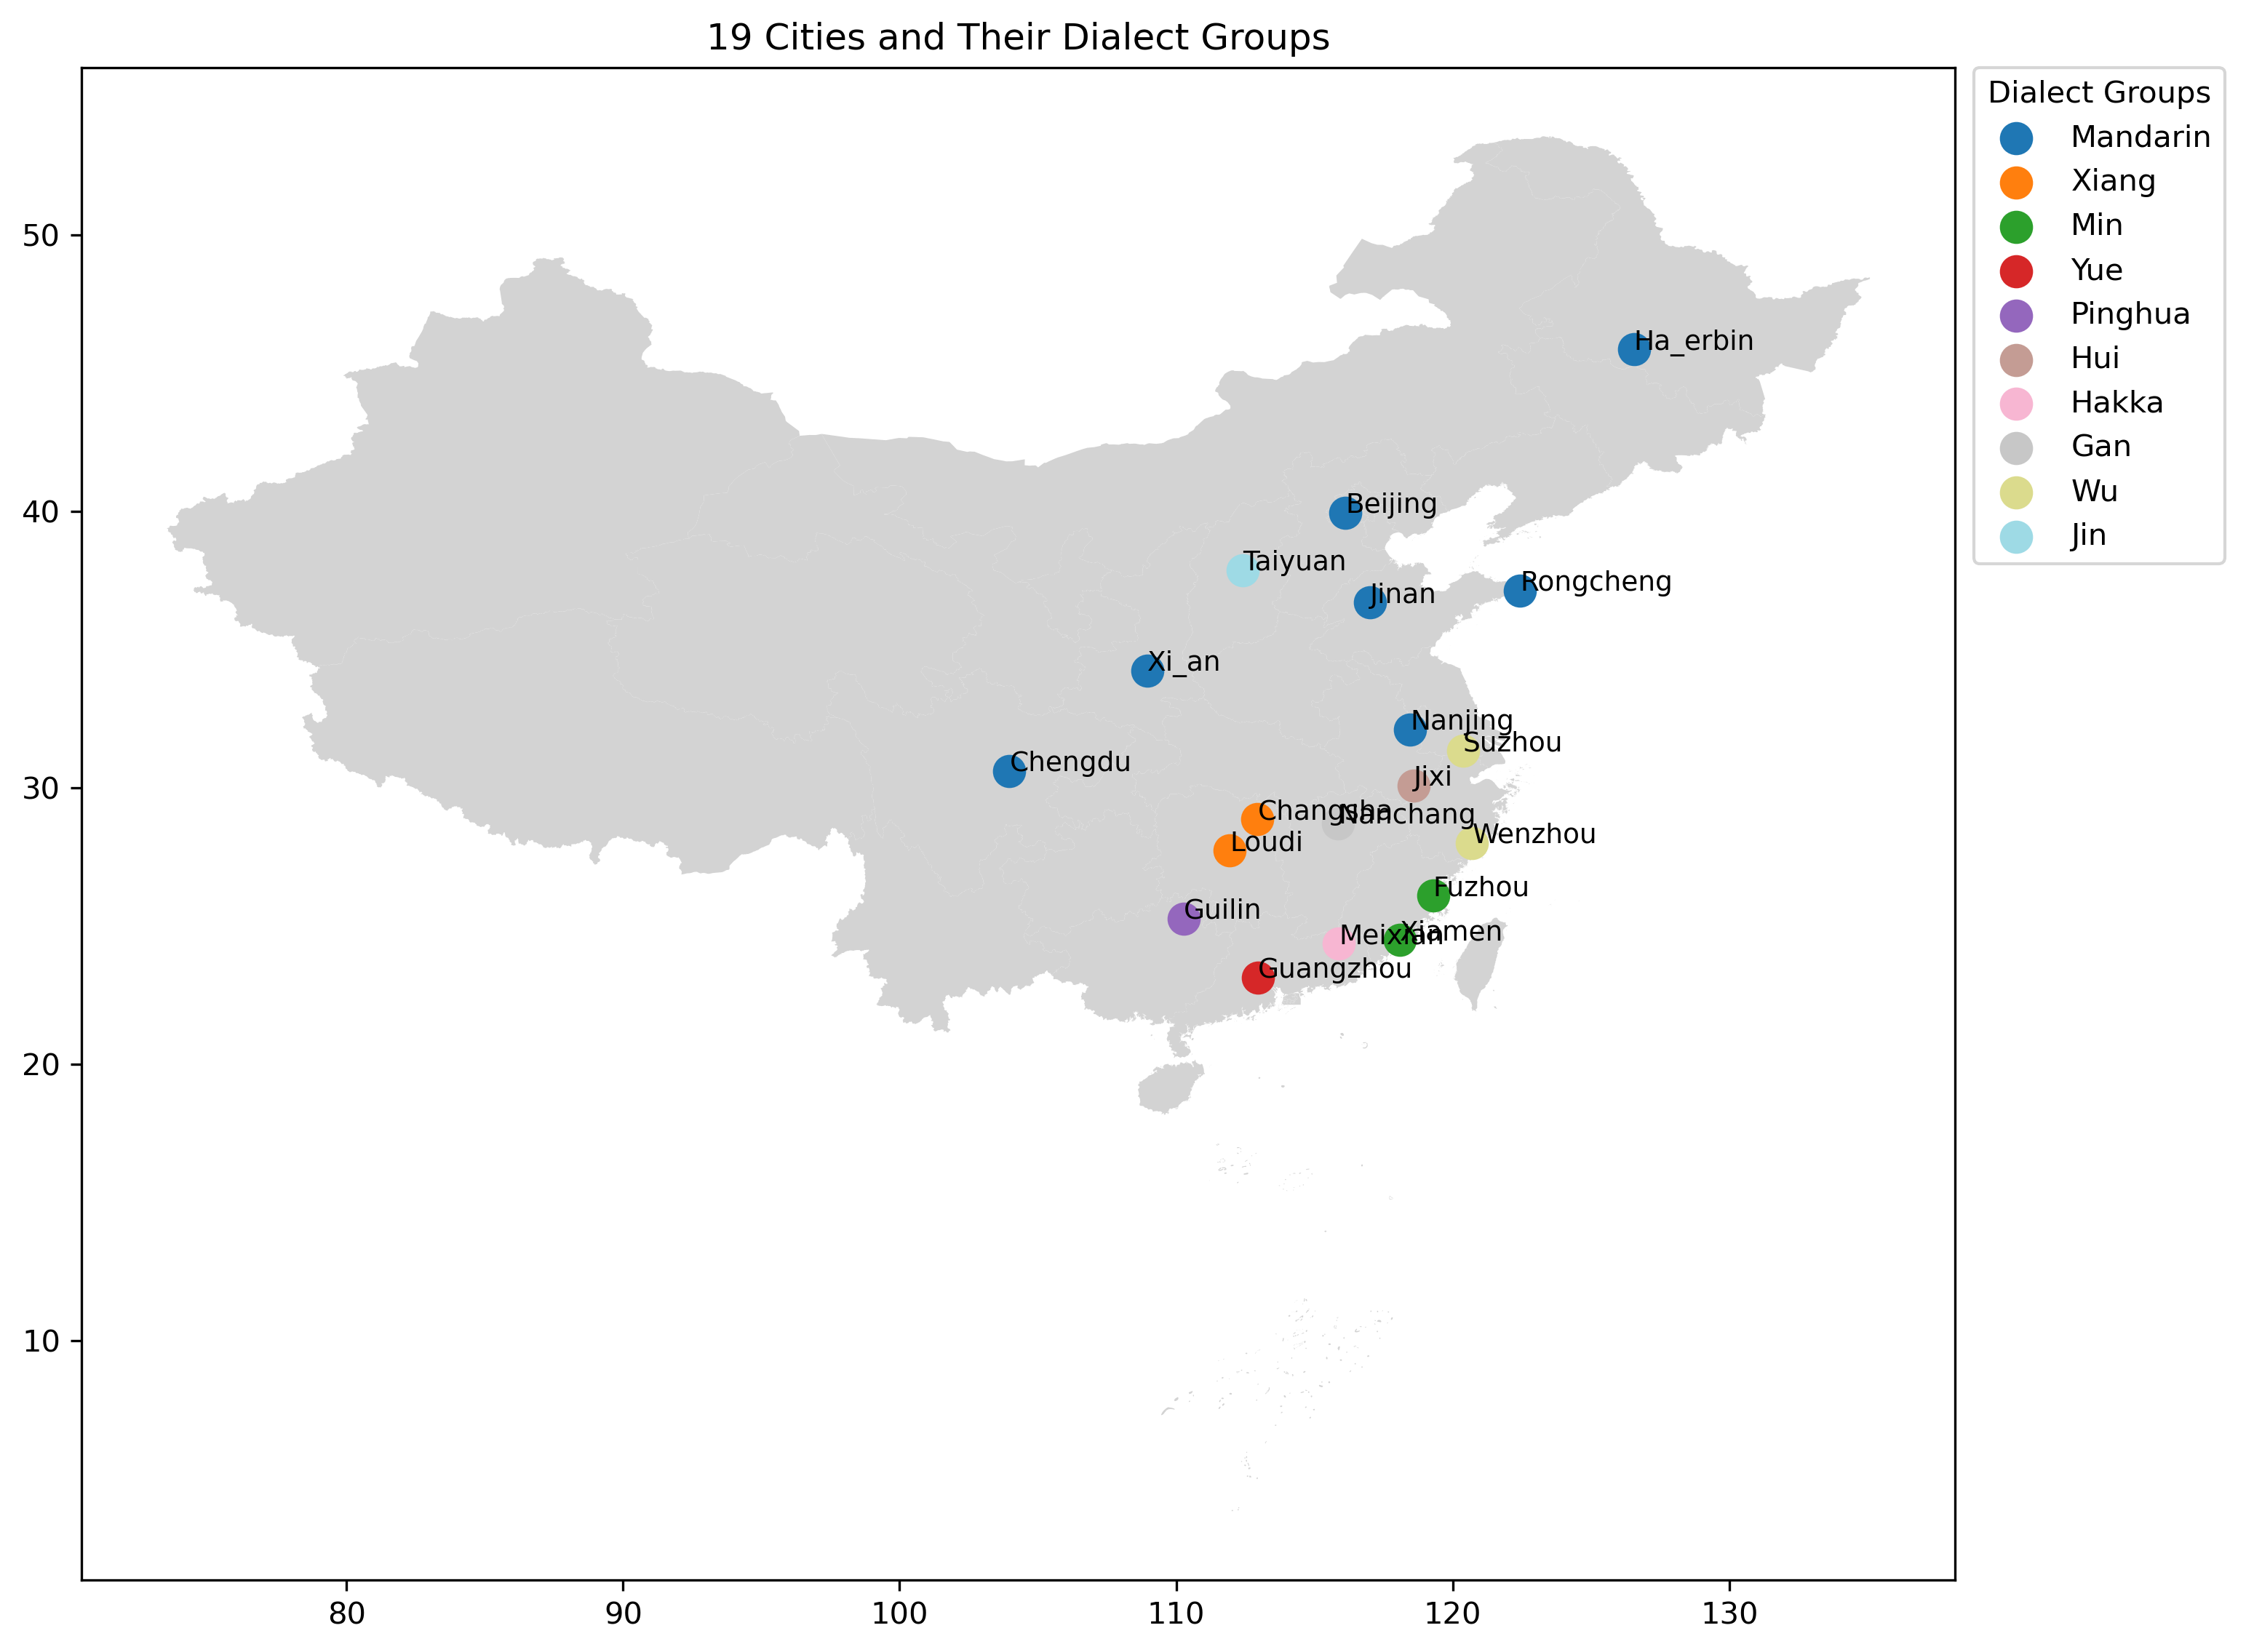

In [28]:
# create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    languages_df, geometry=gpd.points_from_xy(languages_df['Longitude'], languages_df['Latitude'])
)

# load a China shapefile 
# https://github.com/dongli/china-shapefiles
china = gpd.read_file('china.shp')

# assign a color to each dialect group
dialect_groups = gdf['DialectGroup'].unique()
colors = plt.cm.get_cmap('tab20', len(dialect_groups))  

# plot the map
fig, ax = plt.subplots(figsize=(15, 9), dpi=300)
china.plot(ax=ax, color='lightgray')

# plot cities with colors based on dialect group
for i, group in enumerate(dialect_groups):
    subset = gdf[gdf['DialectGroup'] == group]
    subset.plot(ax=ax, color=colors(i), markersize=99, label=group)

# add city labels from languages.csv
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Name']):  
    ax.text(x, y, label, fontsize=9)

plt.legend(title='Dialect Groups', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.title('19 Cities and Their Dialect Groups')
plt.show()


In [29]:
similarity_df = pd.read_csv('similarity.csv')
similarity_df.head()

,ID,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,Jixi,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
0,Beijing_吐,1.000,1.000,1.000,1.0,1.0,1.0,1.0,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,0.462,0.462
1,Haerbin_吐,1.000,1.000,1.000,1.0,1.0,1.0,1.0,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,0.462,0.462
2,Jinan_吐,1.000,1.000,1.000,1.0,1.0,1.0,1.0,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,0.462,0.462
3,Rongcheng_嘔 吐,0.581,0.581,0.581,1.0,NaN,1.0,NaN,0.581,NaN,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.0,0.581,0.581
4,XiAn_嘔 吐,0.581,0.581,0.581,1.0,NaN,1.0,NaN,0.581,NaN,0.793,0.581,0.581,0.376,0.793,0.305,0.581,1.0,0.581,0.581


To compare one city with other 18 cities, just extract one column data for that city and visualise it. To enhance more interest, I used potly library.

In [30]:
#get Beijing data
beijing_df = similarity_df [['ID','Beijing']].copy()
beijing_df

,ID,Beijing
0,Beijing_吐,1.000
1,Haerbin_吐,1.000
2,Jinan_吐,1.000
3,Rongcheng_嘔 吐,0.581
4,XiAn_嘔 吐,0.581
...,...,...
3635,Nanchang_女 客,0.565
3636,Guilin_女 人,1.000
3637,Guangzhou_女 人,1.000
3638,Fuzhou_伊 姐,0.232


In [34]:
beijing_df['city_name'] = beijing_df.ID.str.split('_').str[0]
beijing_df

,ID,Beijing,city_name
0,Beijing_吐,1.000,Beijing
1,Haerbin_吐,1.000,Haerbin
2,Jinan_吐,1.000,Jinan
3,Rongcheng_嘔 吐,0.581,Rongcheng
4,XiAn_嘔 吐,0.581,XiAn
...,...,...,...
3635,Nanchang_女 客,0.565,Nanchang
3636,Guilin_女 人,1.000,Guilin
3637,Guangzhou_女 人,1.000,Guangzhou
3638,Fuzhou_伊 姐,0.232,Fuzhou


In [35]:
beijing_df.columns


Index(['ID', 'Beijing', 'city_name'], dtype='object')

In [57]:
cities = beijing_df['city_name'].unique()
len(cities)

19

In [36]:
# assign random color to different cities
number_of_colors = 19

# https://stackoverflow.com/questions/28999287/generate-random-colors-rgb
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
color_map = dict(zip(cities, colors))
color_map

{'Beijing': '#94ED0E',
 'Haerbin': '#CFF23A',
 'Jinan': '#F30FF4',
 'Rongcheng': '#47B26A',
 'XiAn': '#B2C807',
 'Nanjing': '#9926BA',
 'Suzhou': '#CA2E03',
 'Wenzhou': '#D45E47',
 'Changsha': '#2D91CA',
 'Loudi': '#FCBA25',
 'Nanchang': '#522D6C',
 'Meixian': '#4B00FA',
 'Guilin': '#DF3E0A',
 'Guangzhou': '#C77E4E',
 'Fuzhou': '#B48829',
 'Xiamen': '#12C7EB',
 'Taiyuan': '#F63935',
 'Chengdu': '#876159',
 'Jixi': '#C0A061'}

The following visualisation can be changed to verify the same sublanguage group 

In [38]:
# random x_coord
beijing_df['x_coord'] = np.random.randint(0, 101, size=len(beijing_df))

# build the figure
fig = go.Figure()

# add scatter
for city in beijing_df['city_name'].unique():
     # check one value in a Series
    if mandarin.isin([city]).any():
        city_data = beijing_df[beijing_df['city_name'] == city]
    #city_data = beijing_df[beijing_df['city_name'] = 'chengdu']
        fig.add_trace(go.Scatter(
        x=city_data['x_coord'], 
        y=city_data['Beijing'],
        mode='markers',
        name=city,
        marker=dict(color=color_map[city], size=5),  
        text=city_data['ID'],  # show ID
        hoverinfo='text+y'  # Show Id and similarity
    ))
    

# update layout
fig.update_layout(
    title='City Similarity Scatter Plot',
    xaxis_title='X Coordinate',
    yaxis_title='Similarity Score',
    yaxis=dict(range=[0, 1]),  # similarity range
    hovermode='closest',
    width=1200,  
    height=800  
)


fig.show()

    

Rongcheng really has some words have low similarity with other mandarin group, 
Because Rongcheng_汉字 looks similar to '汉字‘, I thought there is something wrong, so I get Rongcheng data and checked it manually and found out this is 'Rongcheng-186_husband-1'

In [40]:
rongchen_rows = data_df[data_df.ID.str.split('-').str[0] == 'Rongcheng']

In [41]:
rongchen_rows.to_csv('RC.csv')

In [42]:
if 'Rongcheng-186_husband-1' in ones:
    print('yes')
# only one expression

yes


Xiamen and Fuzhou use same dialects and are neigbouring cities, let's check these two cities.

In [45]:
xiamen_df = similarity_df [['ID','Xiamen']].copy()
xiamen_df['city_name'] = xiamen_df.ID.str.split('_').str[0]
xiamen_df.head()

,ID,Xiamen,city_name
0,Beijing_吐,0.462,Beijing
1,Haerbin_吐,0.462,Haerbin
2,Jinan_吐,0.462,Jinan
3,Rongcheng_嘔 吐,0.581,Rongcheng
4,XiAn_嘔 吐,0.581,XiAn


In [44]:
# random x_coord
xiamen_df['x_coord'] = np.random.randint(0, 101, size=len(beijing_df))

# build the figure
fig = go.Figure()

# add scatter
for city in xiamen_df['city_name'].unique():
        # just choose Fuzhou City 
        city_data = xiamen_df[xiamen_df['city_name'] == 'Fuzhou']
    #city_data = beijing_df[beijing_df['city_name'] = 'chengdu']
        fig.add_trace(go.Scatter(
        x=city_data['x_coord'], 
        y=city_data['Xiamen'],
        mode='markers',
        name=city,
        marker=dict(color=color_map[city], size=5),  
        text=city_data['ID'],  # show ID
        hoverinfo='text+y'  # Show Id and similarity
    ))

# update layout
fig.update_layout(
    title='City Similarity between Xiamen and Fuzhou',
    xaxis_title='X Coordinate',
    yaxis_title='Similarity Score',
    yaxis=dict(range=[0, 1]),  # similarity range
    hovermode='closest',
    width=1200,  
    height=800  
)


fig.show()


Suzhou and Nanjing both belong to Jiangsu province, but they belong to different sublanguages of Chinese, while wenzhou is belonging to the same dialect of Suzhou, let's check the similarity among the three cities. Whether the line Suzhou-Nanjing, Suzhou-Wenzhou share the similar curve? Since there are multiple same data, it is better to draw bar chart to show the comparisons.



In [93]:
# draw the curve line to show the similarity
suzhou_df = similarity_df [['ID','Suzhou']].copy()
suzhou_df['city_name'] = suzhou_df.ID.str.split('_').str[0]

for city in nanjing_df['city_name'].unique():
        # just choose Fuzhou City 
        nanjing_data = suzhou_df[suzhou_df['city_name'] == 'Nanjing']
        wenzhou_data = suzhou_df[suzhou_df['city_name'] == 'Wenzhou']
nanjing_data.head()


,ID,Suzhou,city_name
5,Nanjing_吐,1.000,Nanjing
23,Nanjing_怕,1.000,Nanjing
42,Nanjing_皮 膚,1.000,Nanjing
61,Nanjing_漂 浮,0.381,Nanjing
78,Nanjing_平,1.000,Nanjing


In [94]:
df = pd.DataFrame({
    'Suzhou-Nanjing' : nanjing_data['Suzhou'],
    'Suzhou-Wenzhou' : wenzhou_data['Suzhou']
})
df_clean = df.fillna(0)
df_clean.head()


,Suzhou-Nanjing,Suzhou-Wenzhou
5,1.0,0.000
7,0.0,1.000
23,1.0,0.000
26,0.0,0.544
42,1.0,0.000


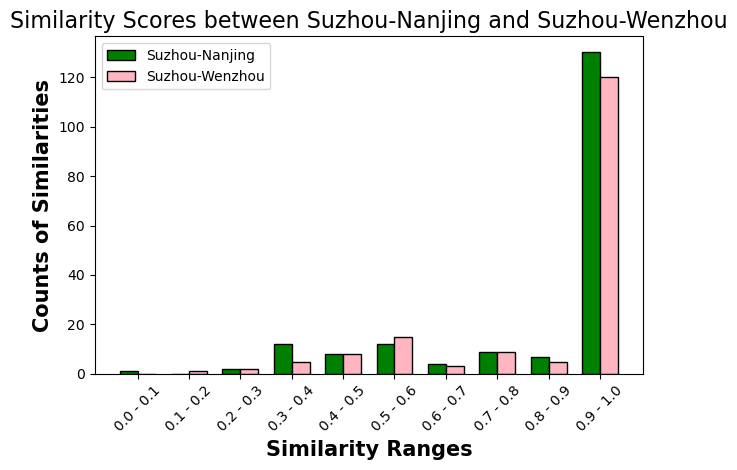

In [97]:
# no need to show 0 data
bins = np.linspace(0.01, 1, 11)  # ten ranges [0, 0.1), [0.1, 0.2), ..., [0.9, 1.0]

# calcute the frequencies (data points of each range)
counts_nanjing, _ = np.histogram(df_clean['Suzhou-Nanjing'], bins=bins)
counts_wenzhou, _ = np.histogram(df_clean['Suzhou-Wenzhou'], bins=bins)

# set the bar width
barWidth = 0.35
x = np.arange(len(counts_nanjing))  

# plot bar chart 
plt.bar(x, counts_nanjing, width=barWidth, color='green', edgecolor='black', label='Suzhou-Nanjing') 
plt.bar(x + barWidth, counts_wenzhou, width=barWidth, color='lightpink', edgecolor='black', label='Suzhou-Wenzhou') 

# add title 
plt.xlabel('Similarity Ranges', fontweight='bold', fontsize=15)
plt.ylabel('Counts of Similarities', fontweight='bold', fontsize=15)
plt.title('Similarity Scores between Suzhou-Nanjing and Suzhou-Wenzhou', fontsize=16)

# x-cord
plt.xticks(x + barWidth / 2, [f"{bins[i]:.1f} - {bins[i + 1]:.1f}" for i in range(len(bins) - 1)], rotation=45)
plt.legend()  
plt.tight_layout()  
plt.show()


The same dialect group languages seem to not have higher similarity than languages that are geographically closer. But this can also caused by that the word2vec model does not have ebough data for traditional chinese characters, for dialects such as Min, Wu and so on.